In [1]:
%%capture
import pandas as pd
import numpy as np
from dp_nlp import *
from dp_validation import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

### Reading and joining conversation data

In [2]:
conversations = pd.read_csv('available_conversations.csv')
topics = pd.read_csv('available_topics.csv')
conversations_with_topics = pd.merge(conversations,topics,on='topic_id')

In [3]:
conversations_with_topics

,message,topic_id,topic_name,topic_description
0,What qualities are you looking for in a candid...,5,talent_acquisition,"Strategies and practices for attracting, recru..."
1,Are there any trainings on virtual team commun...,1,employee_training,Educational programs and development initiativ...
2,What are the options for retirement plans for ...,0,employee_benefits,Programs and perks offered to employees beyond...
3,When will I hear back about the outcome of my ...,5,talent_acquisition,"Strategies and practices for attracting, recru..."
4,Is there a subsidy available for public transp...,0,employee_benefits,Programs and perks offered to employees beyond...
...,...,...,...,...
2495,Can I update my emergency contact information ...,2,other,Miscellaneous topics that do not fit into spec...
2496,Can I make changes to my benefits selections a...,0,employee_benefits,Programs and perks offered to employees beyond...
2497,Can I request a performance improvement plan?,4,performance_management,Processes and systems used to assess and impro...
2498,I have not received my bonus payment. Can you ...,3,payroll,"The process of managing employee salaries, wag..."


Text(0.5, 1.0, 'Distribution of Topic Names')

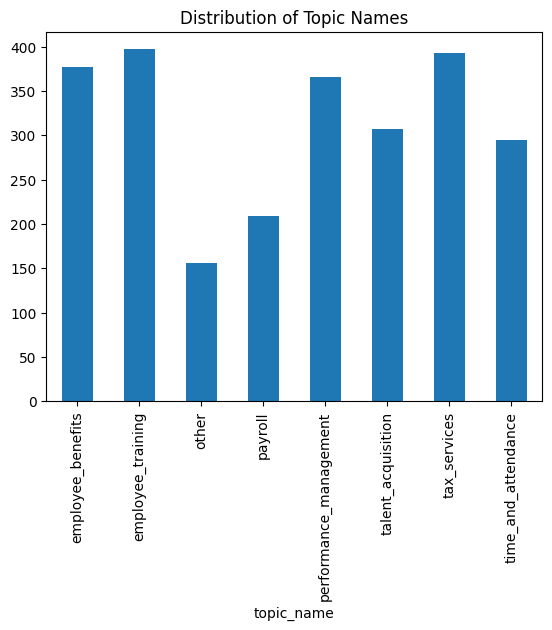

In [4]:
conversations_with_topics.groupby('topic_name')['topic_id'].count().plot(kind='bar')
plt.title('Distribution of Topic Names')

Data seems to be similary distributed across all topics, keeping an eye on `payroll` and `other`

## Data Validation
Text cleaning removing any stop words or punctuations

In [3]:
conversations_with_topics['cleaned_message'] = conversations_with_topics['message'].apply(text_cleaning)
conversations_with_topics['cleaned_topic_description'] = conversations_with_topics['topic_description'].apply(text_cleaning)

conversations_with_topics

,message,topic_id,topic_name,topic_description,cleaned_message,cleaned_topic_description
0,What qualities are you looking for in a candid...,5,talent_acquisition,"Strategies and practices for attracting, recru...",quality looking candidate,strategy practice attracting recruiting hiring...
1,Are there any trainings on virtual team commun...,1,employee_training,Educational programs and development initiativ...,training virtual team communication conflict r...,educational program development initiative enh...
2,What are the options for retirement plans for ...,0,employee_benefits,Programs and perks offered to employees beyond...,option retirement plan employee unique work sc...,program perk offered employee beyond salary he...
3,When will I hear back about the outcome of my ...,5,talent_acquisition,"Strategies and practices for attracting, recru...",hear back outcome job application,strategy practice attracting recruiting hiring...
4,Is there a subsidy available for public transp...,0,employee_benefits,Programs and perks offered to employees beyond...,subsidy available public transportation,program perk offered employee beyond salary he...
...,...,...,...,...,...,...
2495,Can I update my emergency contact information ...,2,other,Miscellaneous topics that do not fit into spec...,update emergency contact information hr mobile...,miscellaneous topic fit specific predefined ca...
2496,Can I make changes to my benefits selections a...,0,employee_benefits,Programs and perks offered to employees beyond...,make change benefit selection submit necessary...,program perk offered employee beyond salary he...
2497,Can I request a performance improvement plan?,4,performance_management,Processes and systems used to assess and impro...,request performance improvement plan,process system used ass improve employee perfo...
2498,I have not received my bonus payment. Can you ...,3,payroll,"The process of managing employee salaries, wag...",received bonus payment check status,process managing employee salary wage bonus de...


### Vectorization for cosine similarity

In [6]:
conversations_with_topics['message_embedding'] = conversations_with_topics['cleaned_message'].apply(get_bert_embeddings_similarity)
conversations_with_topics['topic_description_embedding'] = conversations_with_topics['cleaned_topic_description'].apply(get_bert_embeddings_similarity)

In [7]:
message_embeddings = np.vstack(conversations_with_topics['message_embedding'].values)
topic_description_embeddings = np.vstack(conversations_with_topics['topic_description_embedding'].values)

### Cosine similarity

In order to measure the quality of data, we want to calculate cosine similarity between the `message` and the `topic_description`. This way we can identify any red flags created by miss labelling (Human error)

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = cosine_similarity(message_embeddings, topic_description_embeddings)
conversations_with_topics['similarity_score'] = [similarity_scores[i, i] for i in range(len(conversations_with_topics))]

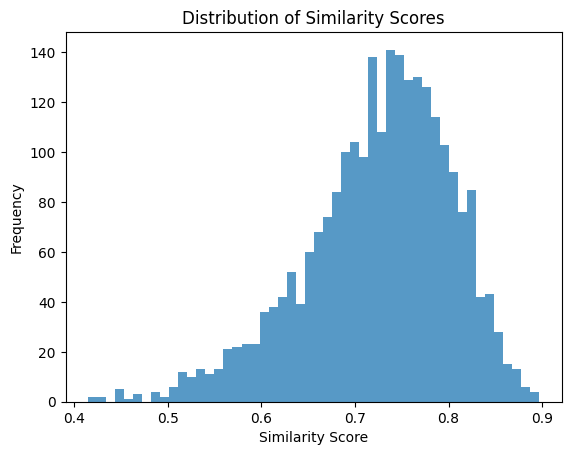

In [9]:
# Plot the distribution of similarity scores
plt.hist(conversations_with_topics['similarity_score'], bins=50, alpha=0.75)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

In [10]:
high_similarity_threshold = 0.75
moderate_similarity_threshold = 0.4


conversations_with_topics.loc[conversations_with_topics['similarity_score'] >= 0.75,'similarity_bucket'] = 'high'
conversations_with_topics.loc[(conversations_with_topics['similarity_score'] < 0.75) & ((conversations_with_topics['similarity_score'] >= 0.5)),'similarity_bucket'] = 'moderate'
conversations_with_topics.loc[conversations_with_topics['similarity_score'] < 0.5,'similarity_bucket'] = 'warning'

<Axes: xlabel='similarity_score', ylabel='Count'>

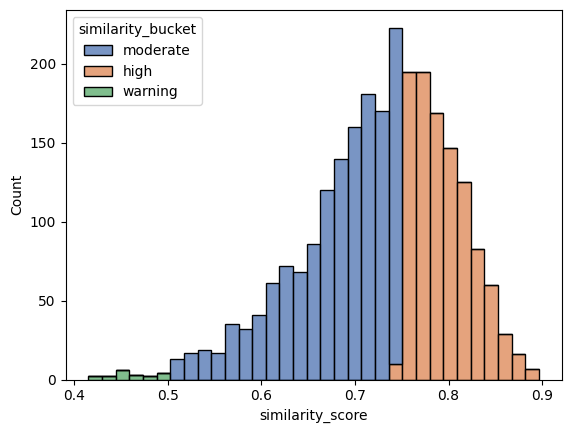

In [11]:
import seaborn as sns

sns.histplot(data=conversations_with_topics, x='similarity_score', hue='similarity_bucket', multiple='stack',palette='deep')

The overall quality of the labelling seems to be good, as messages and tend to match their description. There might be the opportunity to improve the quality of the data by looking at cases where similarity scores are lower

<Axes: xlabel='topic_name'>

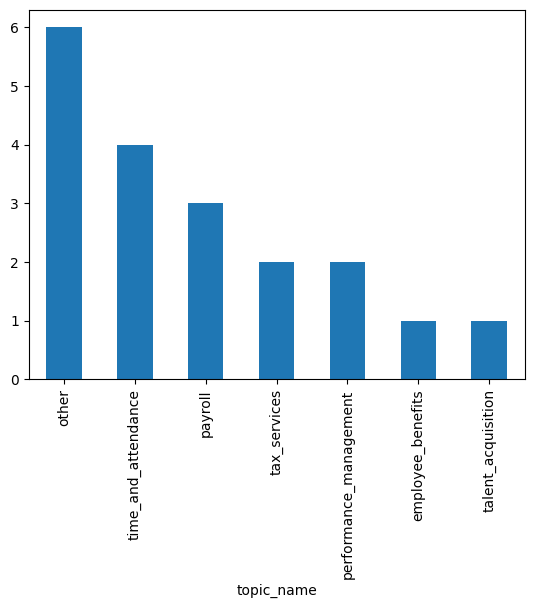

In [12]:
conversations_with_topics[conversations_with_topics['similarity_score']<0.5]['topic_name'].value_counts().plot(kind='bar')

The majority of cases where the cosine similarity is lower (<0.5) is in the topic `other`, but it would be interesting to further analyse the other cases and try to understand whether there has been any errors made.

### Vectorization for Classification

To build the best model possible given limited computational resources and data we use BERT embeddings to train the models

In [13]:
conversations_with_topics['message_embedding'] = list(get_bert_embeddings_classification(conversations_with_topics['cleaned_message'].to_list()))

In [14]:
embeddings = pd.DataFrame(conversations_with_topics['message_embedding'].tolist())
data = pd.concat([embeddings, conversations_with_topics['topic_id']], axis=1)

In [15]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,topic_id
0,-0.407471,0.136019,-0.163733,0.109130,-0.270670,0.057474,0.337460,0.173241,-0.127512,-0.251214,...,-0.277561,0.269468,0.045618,0.075176,-0.130950,-0.161837,-0.136086,0.209851,0.379018,5
1,-0.158563,-0.117043,-0.094236,-0.058129,-0.097511,-0.135978,0.431179,0.227104,-0.285544,-0.471303,...,-0.390914,0.251987,0.102440,0.001805,0.138867,-0.317917,-0.343339,-0.133795,0.252174,1
2,-0.264371,-0.253675,-0.208250,-0.080020,0.491835,0.011435,0.175420,0.329587,-0.582018,-0.402097,...,-0.387785,-0.150377,0.073817,0.046312,-0.185542,-0.358764,-0.311874,-0.309249,0.405564,0
3,-0.234888,-0.104250,-0.055412,0.060247,-0.130268,-0.159874,0.186588,0.297619,-0.058392,-0.247030,...,-0.247500,0.103502,0.152162,0.045877,0.004402,-0.236439,-0.345633,0.017106,0.270244,5
4,-0.694774,0.117740,0.153905,0.028447,0.382660,-0.252072,0.544026,1.045083,-0.318810,-0.440082,...,-0.569864,0.119118,-0.066645,0.098262,0.006955,0.265900,-0.399226,-0.348734,0.887626,0


In [89]:
X = data.drop(columns='topic_id').values
y = data['topic_id'].values
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

### Machine Learning Models

We iterate through some classic ML models and select the best performing one using cross-validation

In [93]:
import numpy
rf_model = RandomForestClassifier(n_estimators=100, random_state=12)
mean_accuracy_rf = kfold_cross_validation(X, y, rf_model, n_splits=5,threshold=0.5)

Mean Accuracy: 0.5952
Mean Precision: 0.9556853965012444
Mean Recall: 0.5952
Mean F1 Score: 0.7136591487471963
Mean Log Loss: 0.7270107899172621


In [95]:
xgb_model = XGBClassifier(eval_metric='mlogloss')
mean_accuracy_xgb = kfold_cross_validation(X, y, xgb_model, n_splits=5,threshold=0.5)

Mean Accuracy: 0.8756
Mean Precision: 0.9185745099887423
Mean Recall: 0.8756
Mean F1 Score: 0.8948903858246016
Mean Log Loss: 0.35996139293213075


In [94]:
svm_model = SVC(probability=True)
mean_accuracy_svm = kfold_cross_validation(X, y, svm_model, n_splits=5,threshold=0.5)

Mean Accuracy: 0.8876
Mean Precision: 0.9349993802566884
Mean Recall: 0.8876
Mean F1 Score: 0.909472775534433
Mean Log Loss: 0.28790637133259517


### Conclusion

Looking at the results above the best performing model is the SVM.

- We have 88.7% accuracy indicating that the SVM model predicts 88.7% of topics correctly
- The model is making highly accurate positive predictions with a precision of ~93.5%. If we estimate the cost of FT and FN we could optimise the threshold
- The high F1 score confirms that the model is well balanced
- Log loss is telling us that when the model is predicting is doing so with high confidence given high probabilities

### Next steps (If we had more time and/or computational power)

- As mentioned above, would be interesting to dig deeper in the data and understand where cosine similarities are lower in order to improve the data quality
- Adding other types of data, as we used an SVM model, we could take advantage of this to add other variables that could help improve the performance of the model (Customer data, time, etc.)
- Estimating the costs of errors could help optimise the threshold to be best suited for this case study
- With more data and computational power we could use transfer learning and tune a larger model